In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from scipy.stats import zscore
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
# These are boilerplate settings provided by Prof. Memo

# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 500)

# switch to seaborn default stylistic parameters
# see the very useful https://seaborn.pydata.org/tutorial/aesthetics.html
sns.set()
sns.set_context('notebook')   
# sns.set_context('paper')  # smaller
# sns.set_context('talk')   # larger

# change default plot size
rcParams['figure.figsize'] = 9,7

In [3]:
url = "life_expectancy_data.csv"
df = pd.read_csv(url)

# I. Data Exploration and Preprocessing

First, we take a broad view of our data set. We can see that we must address the following issues during preprocessing:
- Several features contain null values.
- Column names are inconsistently formatted and hard to work with.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

#### I.I - % Missing Values by Numerical Feature
We can see below that none of the features miss enough values to meet the threshold to be dropped. However, the concern is that we cannot easily fill the gaps for some features.

For example, GDP and Population should not be filled with the median values. They could be completely different based on the country they represent.

One option is to feel each missing value with the median for the status of the country (developed or developing). Another option is to drop the record only if they are missing both "gdp and "population".

After discussion with Prof. Memo, we decided to use KNN imputer to fill missing values for this experiment.

In [5]:
print("% Missing Values per feature:")
print(((df.isna().sum() / len(df)) * 100).round(2))

% Missing Values per feature:
Country                             0.00
Year                                0.00
Status                              0.00
Life expectancy                     0.34
Adult Mortality                     0.34
infant deaths                       0.00
Alcohol                             6.60
percentage expenditure              0.00
Hepatitis B                        18.82
Measles                             0.00
 BMI                                1.16
under-five deaths                   0.00
Polio                               0.65
Total expenditure                   7.69
Diphtheria                          0.65
 HIV/AIDS                           0.00
GDP                                15.25
Population                         22.19
 thinness  1-19 years               1.16
 thinness 5-9 years                 1.16
Income composition of resources     5.68
Schooling                           5.55
dtype: float64


In [6]:
# standardize formatting of column names
for column in df.columns:
    df.rename(columns={column: column.strip().lower()}, errors='raise',inplace=True)

#### I.II - Dropping Records from Target Variable
We decided to drop the 10 rows containing null values for our target variable, 'life expectancy, rather than impute them. This is because we are using KNN imputer, which imputes missing values based on neighboring features. We did not feel that it would make sense to impute and predict the target value from subset of predictors.

In [7]:
# drop rows with missing target values
df.dropna(subset=['life expectancy'], inplace = True)

#### I.III - Dropping Records from Subset of Possible Predictors
We drop the nonumerical features, country and status. We also drop year because our goal is not to perform a time series regression.

Status could be converted to a numerical feature via one hot encoding. However, the examination of the data set reveals that of the two possible values ('developed' and 'developing), around 87% of samples are classified as developing. We did not feel that inclusion of this feature would assist in making more accurate predications.

In [8]:
df.drop(columns=['country','year','status'], inplace=True)

#### I.IV - Imputing Missing Values
For all other missing values, we used KNN imputer to fill in the gaps.

In [9]:
# impute missing values
imputer = KNNImputer(n_neighbors=9)
df = pd.DataFrame(data=imputer.fit_transform(df), columns=df.columns)

#### I.V - Analysis of Describe()

We can immediately see many issues with the data. It seems that there are several extreme outliers.

For example, there are countries with:
- 723 Adult mortalities per 1000 population
- 1800 infant deaths per 1000 population 
- 19479% GDP expenditure on healthcare

Outside of this report, we have experimented with removing outliers with the following methods:
- Using zscore to remove outliers beyond 3 standard deviations from the mean of a feature
- Removing the 1% of largest and smallest measurements from a feature

However, they did not seem to make a measurable difference in the outcome of any of our experiments, so they have not been included. In the case of z-score, it may be that many features are not normally distributed, which we will see in upcoming data visualizations. Many features also have standard deviations large enough that zscore cannot be used to filter all outliers.

It is worth noting that the **standard deviation of life expectancy** is **9.52**. We will be benchmarking the results of our experiments by comparing them to this value.

In [10]:
df.describe()

,life expectancy,adult mortality,infant deaths,alcohol,percentage expenditure,hepatitis b,measles,bmi,under-five deaths,polio,total expenditure,diphtheria,hiv/aids,gdp,population,thinness 1-19 years,thinness 5-9 years,income composition of resources,schooling
count,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2928.000000,2.928000e+03,2928.000000,2928.000000,2928.000000,2928.000000
mean,69.224932,164.796448,30.407445,4.653297,740.321185,81.075061,2427.855874,38.114268,42.179303,82.510663,5.946837,82.278461,1.747712,6757.414730,1.204255e+07,4.878214,4.907776,0.624862,11.948691
std,9.523867,124.292079,118.114450,3.982811,1990.930605,23.248301,11485.970937,19.899112,160.700547,23.381928,2.416950,23.685691,5.085542,13337.944094,5.476545e+07,4.406575,4.493994,0.208376,3.313797
min,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.370000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,63.100000,74.000000,0.000000,1.100000,4.853964,75.444444,0.000000,19.375000,0.000000,78.000000,4.331667,78.000000,0.100000,477.888832,4.127125e+05,1.600000,1.600000,0.491000,10.000000
50%,72.100000,144.000000,3.000000,3.840000,65.611455,91.000000,17.000000,43.000000,4.000000,93.000000,5.790000,93.000000,0.100000,1655.281935,2.265393e+06,3.400000,3.400000,0.673000,12.300000
75%,75.700000,228.000000,22.000000,7.712500,442.614322,96.000000,362.250000,56.100000,28.000000,97.000000,7.440000,97.000000,0.800000,5393.227337,7.950236e+06,7.200000,7.300000,0.775833,14.200000
max,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,77.600000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


#### I.VI Data Exploration - Correlated Features Overview

We continue exploration by visualizing correlated features via heatmap.

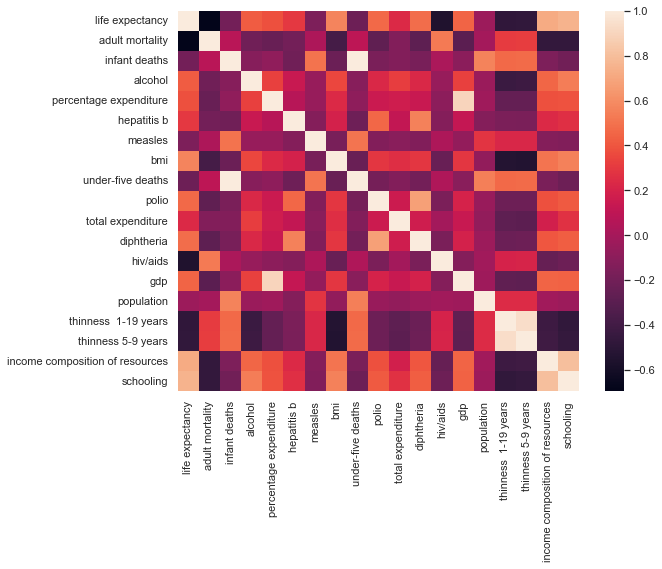

In [11]:
# Showing a general heatmap of correlation between features
corr = df.corr()
sns.heatmap(corr);

#### I.VII Data Exploration - Most Strongly Correlated Features
This visualization shows the highly correlated features in the set of possible predictors. The most highly correlated features appear to be:
- 'under five deaths' and 'infant deaths' = 1.0
- 'gdp' and 'percentage expenditure' = .9
- 'thinness 1-19 years' and thinness '5-9' years = .94
- 'income composition of resources' and 'schooling' = .81

Dropping one member of each pair of highly correlated features may improve the accuracy of our model.

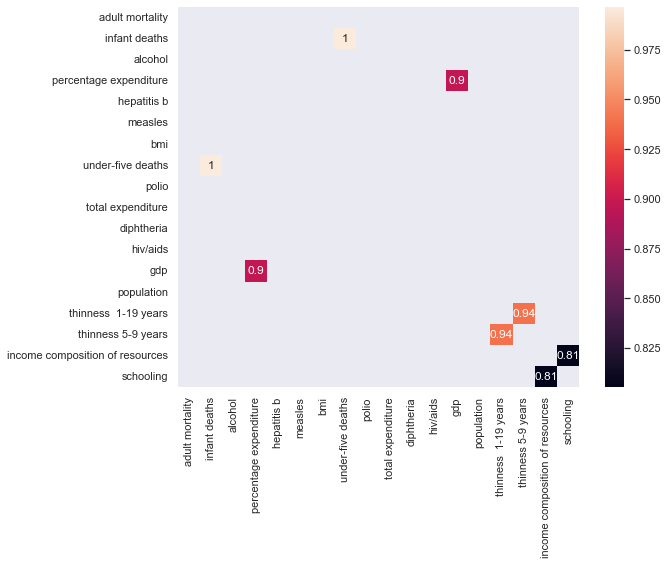

In [12]:
strong_relationship = corr[((corr >= .7) | (corr <= -.6)) & (corr != 1.0)]

sns.heatmap(strong_relationship.drop(columns='life expectancy').drop(labels='life expectancy'), annot=True);


#### I.VIII Data Exploration - Correlation with Target Feature
We continue data exploration by identifying the target variable's ('life expectancy') three most positively and negatively correlated features. We selected these features for even further exploration.

In [13]:
# Top 3 features most highly positively correlated with life expectancy
p_corr = df.corr()['life expectancy'].sort_values(ascending=False)[1:4]
p_corr.round(3)

schooling                          0.750
income composition of resources    0.721
bmi                                0.569
Name: life expectancy, dtype: float64

In [14]:
# Top 3 features most highly negatively correlated with life expectancy
n_corr = df.corr()['life expectancy'].sort_values()[:3]
n_corr.round(3)

adult mortality        -0.696
hiv/aids               -0.557
thinness  1-19 years   -0.479
Name: life expectancy, dtype: float64

#### I.VIII Data Exploration - Visualization of Highly Correlated Features
We continue our exploration by further examining the 6 predictors that are the most correlated with our target variable.

Below, we have displayed:
- the heatmap of each correlated feature, excluding 'life expectancy'
- the pairplot of each feature excluding 'life expectancy'
- scatterplots of each feature vs 'life expectancy'

Through our visualization, we want to further:
1. identify strongly correlated features in the subset of predictors.
2. identify potential features that may benefit from feature engineering.

The heatmap allows us to address the first issue. We identify strongly correlated features so that we can potentially drop them from the set of predictors.

The pairplots help us with the second issue. By seeing how the data is distributed, we can identify potential transformations (such as squaring or taking the log) that may help us in the future. We further expand on our use of visualizations during our linear regression experiments.

<AxesSubplot:>

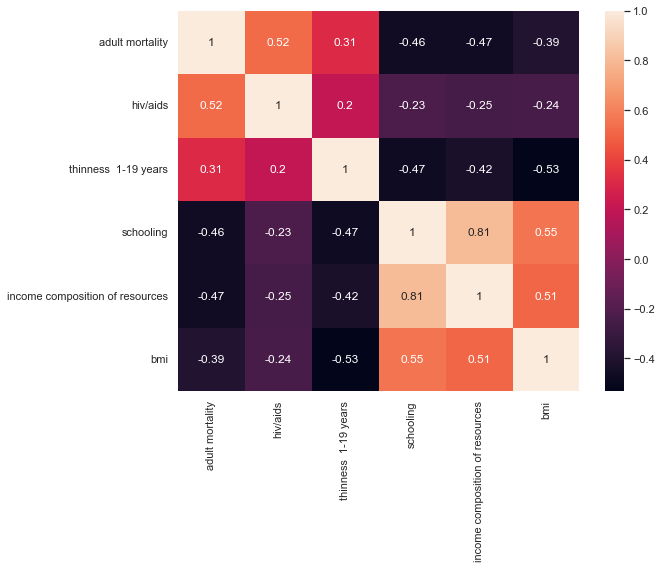

In [15]:
features = n_corr.index.tolist() + p_corr.index.tolist()

sns.heatmap(df[features].corr(), annot=True)

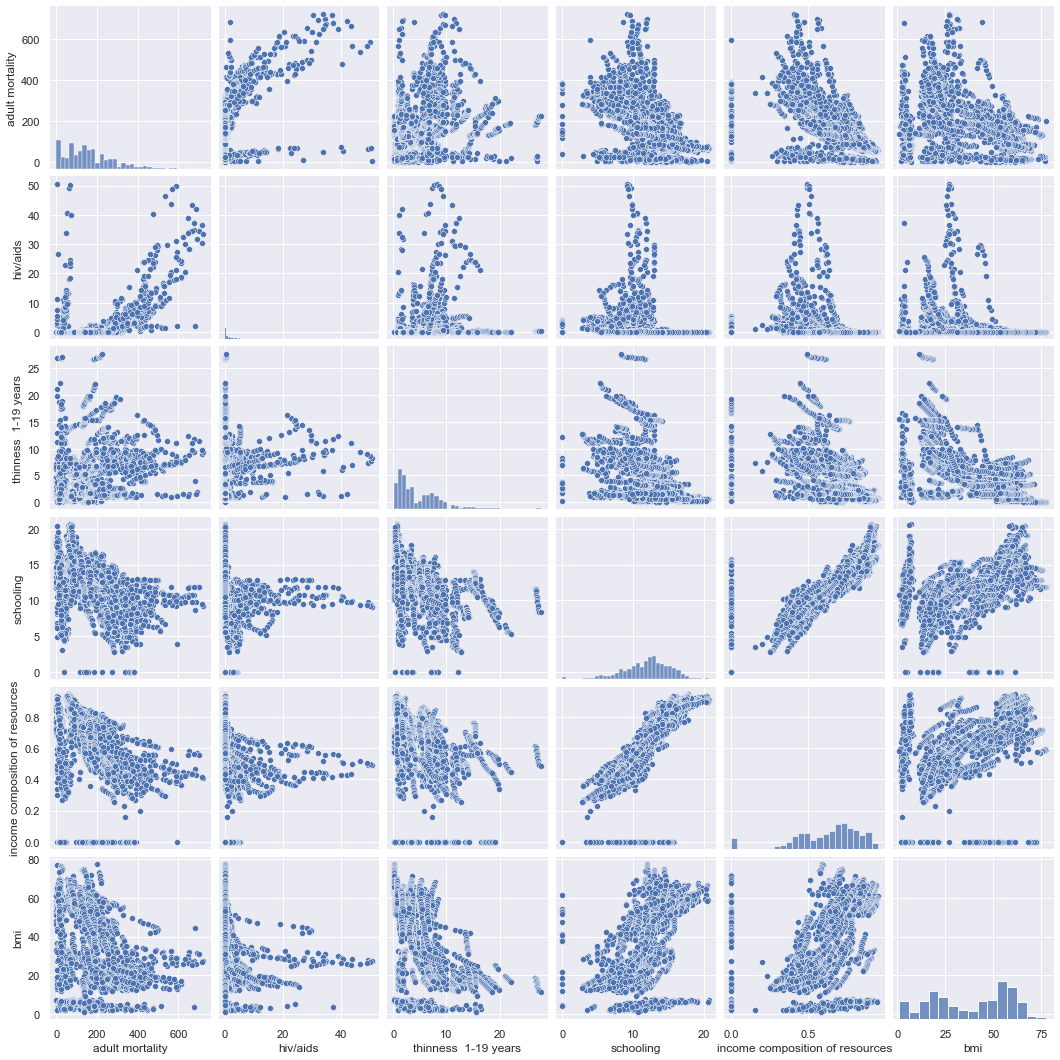

In [16]:
sns.pairplot(df[features]);

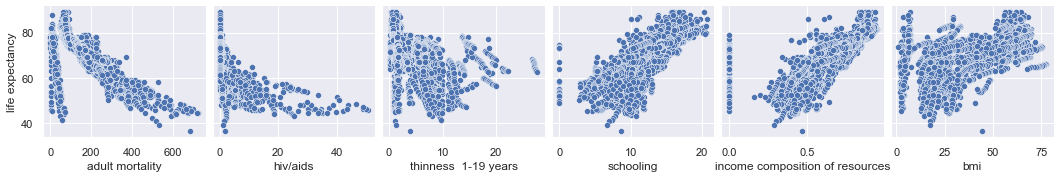

In [17]:
sns.pairplot(data=df, x_vars=features, y_vars=['life expectancy']);

# II. Linear Regression Experiments
Making use of the information gained through data exploration, we attempted 3 experiments and observe the resulting RMSE:
- Including all features to establish baseline values
- Including select features without feature engineering
- Removing select features and including engineered features in the model

In [18]:
def rmse(actual, predicted):
    return np.sqrt(((actual-predicted)**2).mean())

#### II.I - Experiment 1: Baseline RMSE

In [19]:
# Fit and train model, then predict

target = 'life expectancy'
predictors = df.columns.tolist()
predictors.remove(target)

X = df[predictors].values
X = RobustScaler().fit_transform(X) # Not required but scaling helps interperet coefficients
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
predicted = reg.predict(X_test)

#### II.I.I - Experiment 1: Results
We note the following:
- The blind RMSE is 9.7, which very close to but slightly above the feature's standard deviation of 9.5
- The baseline RMSE is 4.0 (including all features with no engineering), which is within 1/2 of a standard deviation (.42 std). 

In [20]:
baseline = rmse(y_train.mean(), y_test).round(1)
print(f"Baseline 'blind' RMSE: {baseline}")

exp1 = rmse(predicted, y_test).round(1)
print(f"Baseline 'test' RMSE: {exp1}")

r2 = reg.score(X_train, y_train)
print(f'training rsquared:{r2:.2f}')

Baseline 'blind' RMSE: 9.7
Baseline 'test' RMSE: 4.0
training rsquared:0.83


#### II.II.II - Experiment 1: Impact of Coefficients

In [21]:
print('Coefficients per feature:')
for i, coef in enumerate(reg.coef_):
    print(f"  {predictors[i]}: {coef:.3f}")

Coefficients per feature:
  adult mortality: -2.886
  infant deaths: 2.234
  alcohol: 0.779
  percentage expenditure: 0.032
  hepatitis b: -0.153
  measles: -0.008
  bmi: 1.240
  under-five deaths: -2.082
  polio: 0.519
  total expenditure: 0.155
  diphtheria: 0.529
  hiv/aids: -0.357
  gdp: 0.234
  population: -0.024
  thinness  1-19 years: -0.457
  thinness 5-9 years: -0.123
  income composition of resources: 1.745
  schooling: 3.089


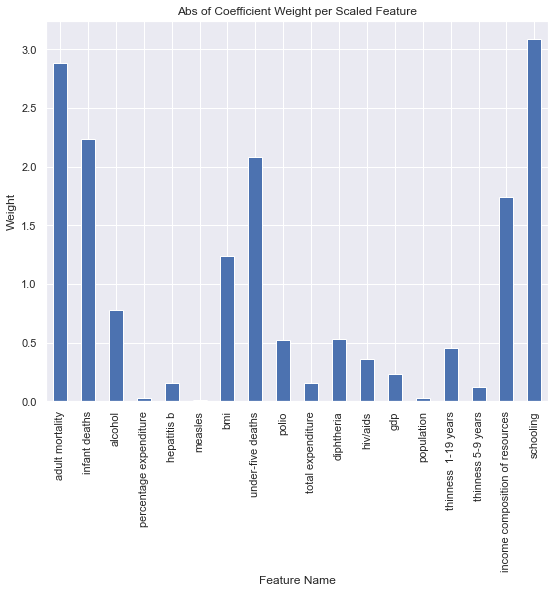

In [22]:
# We took the absolute value of the coefficient because we are most interested 
# in comparing overall impact (positive and negative)

pd.Series(data=np.abs(reg.coef_), index=predictors).plot.bar()
plt.title('Abs of Coefficient Weight per Scaled Feature')
plt.ylabel('Weight')
plt.xlabel('Feature Name');

#### II.II - Experiment 2: Including Select Features Without Feature Engineering
In this experiment, we attempted the following:

- Include predictors that were found to be highly correlated with the target during our data exploration phase.
- Excluded 'income composition of resources', which was found to be highly correlated with 'schooling' but less correlated with 'life expectancy' in comparison

However, our resulting test RMSE was actually higher than our baseline test RMSE (experiment 1).

In [23]:
# Fit and train model, then predict

target = 'life expectancy'
predictors = ['schooling', 'bmi', 'adult mortality', 'hiv/aids', 'thinness  1-19 years']

X = df[predictors].values
X = RobustScaler().fit_transform(X) # Not required but scaling helps interperet coefficients
y = df[target].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
predicted = reg.predict(X_test)

In [24]:
baseline = rmse(y_train.mean(), y_test).round(1)
print(f"Baseline 'blind' RMSE: {baseline}")

print(f"Experiment 1 RMSE: {exp1}")

exp2 = rmse(predicted, y_test).round(1)
print(f"Experiment 2 RMSE: {exp2}")

r2 = reg.score(X_train, y_train)
print(f'training rsquared:{r2:.2f}')

Baseline 'blind' RMSE: 9.7
Experiment 1 RMSE: 4.0
Experiment 2 RMSE: 4.5
training rsquared:0.78


####  II.III - Experiment 3: Including Select Features with Feature Engineering
In this experiment, we observed the shape of select features and engineered new features accordingly. We included a slightly different subset of predictors in an attempt to improve test RMSE.

First, we perform data exploration on four features of interest:
- percentage expenditure
- gdp
- hiv/aids
- bmi

It seems that with the exception of 'bmi', the log of these features is more highly correlated with 'life expectancy'.

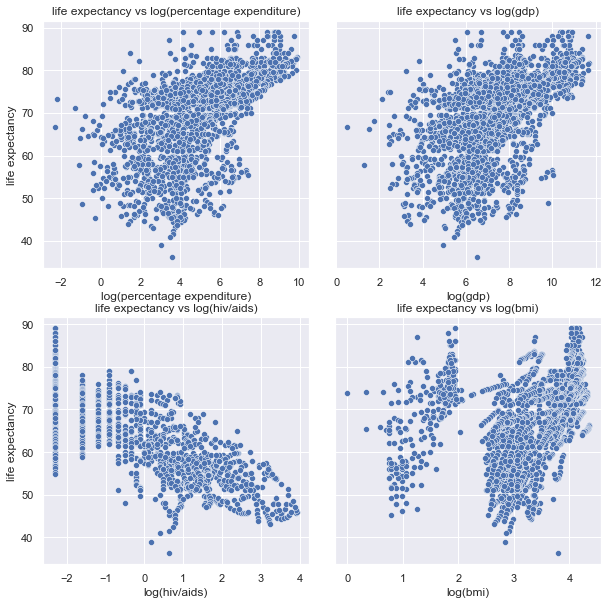

In [25]:
rows, cols = 2, 2
fig, ax = plt.subplots(rows, cols, sharey=True, figsize=(10,10))
engr_feat = ['percentage expenditure', 'gdp', 'hiv/aids', 'bmi']
index = 0

for row in range(rows):
    for col in range(cols):
        if index < len(engr_feat):
            plt.sca(ax[row, col])
            plt.subplots_adjust(wspace = 0.1)
            with np.errstate(divide='ignore'): # suppressing warnings for exploration
                sns.scatterplot(x=np.log(df[engr_feat[index]]),y=df['life expectancy']);
                plt.xlabel(f"log({engr_feat[index]})")
                plt.title(f'life expectancy vs log({engr_feat[index]})')
            index += 1

In [26]:
target = ['life expectancy']
baseline_corr = df[target + engr_feat].corr()['life expectancy'].iloc[1:].values

engr_df = pd.DataFrame()
engr_df[target[0]] = df[target[0]]
for feat in engr_feat:
    with np.errstate(divide='ignore'): #suppressing warnings for exploration
        engr_df[f'log({feat})'] = np.log(df[feat])

engr_corr = engr_df.corr()['life expectancy'].iloc[1:].values
print('Correlation of features with target (baseline vs engineered):')
for i, feat in enumerate(engr_feat):
    print(f'[{feat}] baseline:{baseline_corr[i]:.3f}, engineered:{engr_corr[i]:.3f}')

Correlation of features with target (baseline vs engineered):
[percentage expenditure] baseline:0.382, engineered:0.597
[gdp] baseline:0.444, engineered:0.583
[hiv/aids] baseline:-0.557, engineered:-0.813
[bmi] baseline:0.569, engineered:0.423


#### II.III.I - Experiment 3: Creating a New Data Frame
From the above data exploration, we discovered that taking the log of the following features resulted in a feature that is more highly correlated with the target:

- percentage expenditure
- gdp
- hiv aids

We decided to merge these engineered features with our existing dataset. Then, we selected a new subset of predictors containing the above engineered features and the three most highly positively correlated features found during data exploration:

- bmi
- income composition of resources
- schooling

However, we decided not to include log(percentage expenditure). This is because we saw roughly 600 -np.inf values in the resulting series after transformation. We would have to convert these values to NaN and drop rows containing these values in order to continue the experiment, which would result in the loss of almost 1/5th of our data.

In [27]:
# Create a new data frame by merging our engineered features with the original data frame
engr_df.drop(columns=['life expectancy', 'log(bmi)', 'log(percentage expenditure)'], inplace=True)
engr_df = pd.concat([df, engr_df], axis=1)

In [28]:
X = engr_df[['bmi', 
             'income composition of resources', 
             'schooling',
             'log(gdp)', 
             'log(hiv/aids)']].values
y = engr_df['life expectancy'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_train,y_train)
predicted = reg.predict(X_test)

#### II.III.II - Experiment 3: Results
Unfortunately, our test RMSE for Experiment 3 is 4.1, which is still slightly worse compared to our baseline test RMSE of 3.9. As you can see from the below results, our team has experienced difficulty in selecting predictors that would result in more accurate predictions compared to the baseline. 

We decided to continue our experiment with Forward Feature Selection and Polynomial Features to identify the best model and predictors.

In [29]:
print(f"Experiment 1 RMSE: {exp1}")
print(f"Experiment 2 RMSE: {exp2}")

exp3 = rmse(predicted, y_test).round(1)
print(f"Experiment 3 RMSE: {exp3}")

r2 = reg.score(X_train, y_train)
print(f'training rsquared:{r2:.2f}')

Experiment 1 RMSE: 4.0
Experiment 2 RMSE: 4.5
Experiment 3 RMSE: 4.1
training rsquared:0.82


# III. Forward Feature Selection and Polynomial Features
Due to our difficulty in manually engineering and selecting predictors, we have decided to:
- Use a greedy algorithm (forward feature selection) in to select potential best predictors.
- Capture the interaction between features through the use of polynomial features

#### III.I - Forward Feature Selection
For forward feature selection, we've included the engineered features from Experiment 3.

In [30]:
# We drop 'gdp' and 'hiv/aids' because we have the log(feature) transformation in our dataframe
X = engr_df.drop(columns=['life expectancy', 'gdp', 'hiv/aids'])
y = engr_df['life expectancy']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=0)

#### IIII.I.I - Forward Feature Selection: Results
Below are our results from using forward feature selection to pick the features that would result in the lowest test RMSE values. It seems that a minimum of 4 features were picked from the engineered dataset before seeing improvement over the baseline:

- log(gdp)
- income composition of resources
- life expectancy
- schooling

With the above 4 features, our test RMSE was 3.92, which was our first improvement over the baseline RMSE of 4.0.

However, the lowest test RMSE value of 3.63 occured with 15 features selected. These features are also listed in our results below.

In [31]:
remaining = list(range(X_train.shape[1]))
selected = []
rmse_scores = []
n = X_train.shape[1]

print("Test RMSE resulting from predictions made with number of features selected:")
while len(selected) < n:
    rmse_min = 1e7
    for i in remaining:
        X_feat = np.hstack((
            X_train.iloc[:,selected], 
            X_train.iloc[:,[i]]))
        scores = cross_val_score(
            LinearRegression(), 
            X_feat, 
            y_train, 
            scoring='neg_mean_squared_error', 
            cv=5)
        rmse = np.sqrt(-scores.mean())
        if(rmse < rmse_min):
            rmse_min = rmse
            i_min = i
    remaining.remove(i_min)
    selected.append(i_min)
    rmse_scores.append(rmse_min)
    print('  num features: {}; rmse: {:.2f}'.format(len(selected), rmse_min))

Test RMSE resulting from predictions made with number of features selected:
  num features: 1; rmse: 5.56
  num features: 2; rmse: 4.34
  num features: 3; rmse: 4.05
  num features: 4; rmse: 3.92
  num features: 5; rmse: 3.83
  num features: 6; rmse: 3.76
  num features: 7; rmse: 3.71
  num features: 8; rmse: 3.69
  num features: 9; rmse: 3.68
  num features: 10; rmse: 3.67
  num features: 11; rmse: 3.66
  num features: 12; rmse: 3.66
  num features: 13; rmse: 3.65
  num features: 14; rmse: 3.65
  num features: 15; rmse: 3.63
  num features: 16; rmse: 3.63
  num features: 17; rmse: 3.64
  num features: 18; rmse: 3.64


In [32]:
min_score_index = rmse_scores.index(np.min(rmse_scores))
feat = engr_df.columns[selected[:min_score_index + 1]]

print(f'The {min_score_index + 1} best features selected:')
for i in feat:
    print(f" - {i}")

The 15 best features selected:
 - income composition of resources
 - thinness  1-19 years
 - life expectancy
 - thinness 5-9 years
 - total expenditure
 - population
 - hiv/aids
 - alcohol
 - infant deaths
 - hepatitis b
 - under-five deaths
 - polio
 - percentage expenditure
 - bmi
 - adult mortality


#### III.II - Polynomial Features
We continued our experiment by attempting to account for the interaction between features through the use of polynomial features, something that is not normally captured through linear regression.

#### III.II.I - Polynomial Features and Forward Feature Selection
For this experiment, we took the 15 previously selected features and added polynomial and interaction features. Our test RMSE result saw the greatest improvement at 1.82 compared to the baseline of 4.0 and the previous best result of 3.63. However, the training r-squared value was extremely high at .98, suggesting that there is overfitting.

In [33]:
X = engr_df[feat]
y = engr_df['life expectancy']
pf = PolynomialFeatures(degree=2)
pf.fit(X)
X_poly=pf.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=0)
regr = LinearRegression()
regr.fit(X_train, y_train)
predicted = regr.predict(X_test)

rmse = np.sqrt(((y_test - predicted)**2).mean())
r2 = regr.score(X_train, y_train)

print(f'training rsquared:{r2:.2f}')
print(f'test rmse:{rmse:.2f}')

training rsquared:0.98
test rmse:1.82


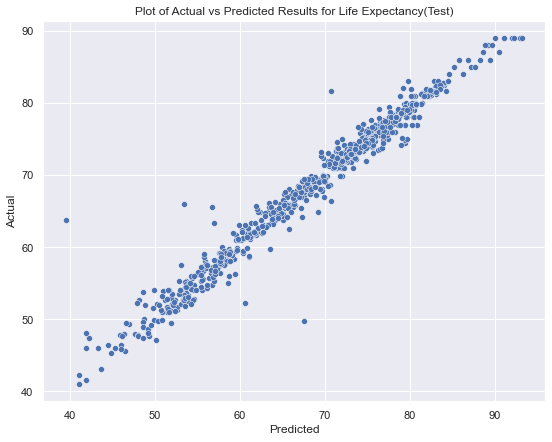

In [34]:
sns.scatterplot(x=predicted,y=y_test)
plt.title('Plot of Actual vs Predicted Results for Life Expectancy(Test)')
plt.xlabel('Predicted')
plt.ylabel('Actual');

#### III.II.II - Polynomial Features applied to previous experiments
Through manual testing, we suspect that higher training r-squared values and overfitting occurs as a higher number of features are included. Due to time constraints, we were not able to fully automate the breadth of testing we thought could confirm this within our data set. However, we further applied polynomial features to our previous experiments to see if they resulted in improvements over the original measurements.

We found that test RMSE and training r-squared measurements had improved over all previous experiments. Although test RMSE values were lower compared to the results of III.II.I, training r-squared values were also lower.

As a note, our original baseline test RMSE measurement was 4.0.

Results:
- The new baseline values (Experiment 1), resulted in a test RMSE of 3.79.
- Experiment 2 saw the largest improvement, with a test RMSE of 3.04 compared to the original 4.5.
- Experiment 3 resulted in a test RMSE of 3.52 compared to its original value of 4.1

When accounting for interaction between features, all our previous attempts at feature selection and engineering seem to have greatly improved results. Even the baseline values are slightly improved. This appears to illustrate the importance of capturing the relationship between predictors when using a linear regression model.

In [35]:
# exp 1
X = df.drop(columns='life expectancy').values
y = df['life expectancy'].values
pf = PolynomialFeatures(degree=2)
pf.fit(X)
X_poly=pf.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=0)
regr = LinearRegression()
regr.fit(X_train, y_train)
predicted = regr.predict(X_test)

rmse = np.sqrt(((y_test - predicted)**2).mean())
r2 = regr.score(X_train, y_train)

print('Polynomial Features - Experiment 1:')
print(f'  training rsquared:{r2:.2f}')
print(f'  test rmse:{rmse:.2f}')

Polynomial Features - Experiment 1:
  training rsquared:0.88
  test rmse:3.79


In [36]:
# exp 2
X = df[['schooling', 'bmi', 'adult mortality', 'hiv/aids', 'thinness  1-19 years']].values
y = df['life expectancy'].values
pf = PolynomialFeatures(degree=3)
pf.fit(X)
X_poly=pf.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=0)
regr = LinearRegression()
regr.fit(X_train, y_train)
predicted = regr.predict(X_test)

rmse = np.sqrt(((y_test - predicted)**2).mean())
r2 = regr.score(X_train, y_train)

print('Polynomial Features - Experiment 2:')
print(f'  training rsquared:{r2:.2f}')
print(f'  test rmse:{rmse:.2f}')

Polynomial Features - Experiment 2:
  training rsquared:0.91
  test rmse:3.04


In [37]:
X = engr_df[['bmi', 
             'income composition of resources', 
             'schooling',
             'log(gdp)', 
             'log(hiv/aids)']].values
y = engr_df['life expectancy'].values
pf = PolynomialFeatures(degree=2)
pf.fit(X)
X_poly=pf.transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.30, random_state=0)
regr = LinearRegression()
regr.fit(X_train, y_train)
predicted = regr.predict(X_test)

rmse = np.sqrt(((y_test - predicted)**2).mean())
r2 = regr.score(X_train, y_train)

print('Polynomial Features - Experiment 3:')
print(f'  training rsquared:{r2:.2f}')
print(f'  test rmse:{rmse:.2f}')

Polynomial Features - Experiment 3:
  training rsquared:0.87
  test rmse:3.52


# IV. Conclusion

The goal of our experiment was to identify the most successful model and predictors in predicting a target value, using lowest test RMSE scores as a basis for determination. We started by performing data preprocessing and visualization. We identified strongly correlated features (within the subset of predictors) that could be potentially dropped, as well as predictors that were strongly correlated with the target variable (that could possibly be included). 

In the first phase of our experiment, we started by finding the baseline RMSE value, which occurs when all predictors are included without engineering. We performed two further experiments. First, we strategically selected predictors that were highly correlated with the target variables and dropped those that were highly correlated with each other. Then, we engineered and included new features that were more correlated with the target variable. Neither experiment accounted for interaction between features and neither performed better than the baseline.

In the second phase of the experiment, we attempted to use forward feature selection to find the best perform set of features. We found that the algorithm was able to select a set of features that would outperform the baseline model, starting at 4 and improving until 15 selected features. This experiment performed better than the baseline but also did not account for interaction between features.

In the final phase of the experiment, we attempted to account for interaction between features through the inclusion of polynomial features. We applied polynomial features to the model we previously created by using forward feature selection on our featured engineered data set. 

This resulted in the model with the best test RMSE at 1.82 and the fifteen selected predictors:  
 - income composition of resources
 - thinness  1-19 years
 - life expectancy
 - thinness 5-9 years
 - total expenditure
 - population
 - hiv/aids
 - alcohol
 - infant deaths
 - hepatitis b
 - under-five deaths
 - polio
 - percentage expenditure
 - bmi
 - adult mortality
 
We applied polynomial features to our first phase of experiments and received our second best model with a test RMSE of 3.04 and the below predictors. This model was previously the most poorly performing model, developed during data exploration and through selective inclusion and exclusion of correlated features: 
- schooling
- bmi
- adult mortality
- hiv/aids
- thinness  1-19 years

We discovered that modeling the interaction between predictors provided the single largest improvement to any of our models, maybe due to the fact that linear regression does not account for these interactions on its own. The caveat is that the larger number of predictors may lead to overfitting of the data. Although it performs the best on our test data, our best model also has a training rsquared value of .98, which implies that we may be overfitting the data. If we had new, unseen data, the model may not perform as well. 